In [28]:
#Import packages
import numpy as np
import pandas as pd
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
import itertools

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Models
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV

In [2]:
df = pd.read_csv('SDSS.csv')

In [3]:
df

objid          ra        dec         u         g         r  \
0     1.237650e+18  183.531326   0.089693  19.47406  17.04240  15.94699   
1     1.237650e+18  183.598371   0.135285  18.66280  17.21449  16.67637   
2     1.237650e+18  183.680207   0.126185  19.38298  18.19169  17.47428   
3     1.237650e+18  183.870529   0.049911  17.76536  16.60272  16.16116   
4     1.237650e+18  183.883288   0.102557  17.55025  16.26342  16.43869   
...            ...         ...        ...       ...       ...       ...   
9995  1.237650e+18  131.316413  51.539547  18.81777  17.47053  16.91508   
9996  1.237650e+18  131.306083  51.671341  18.27255  17.43849  17.07692   
9997  1.237650e+18  131.552562  51.666986  18.75818  17.77784  17.51872   
9998  1.237650e+18  131.477151  51.753068  18.88287  17.91068  17.53152   
9999  1.237650e+18  131.665012  51.805307  19.27586  17.37829  16.30542   

             i         z   run  rerun  camcol  field     specobjid   class  \
0     15.50342  15.22531   752    301       4    267  3.722360e+18    STAR   
1     16.48922  16.39150   752    301       4    267  3.638140e+17    STAR   
2     17.08732  16.80125   752    301       4    268  3.232740e+17  GALAXY   
3     15.98233  15.90438   752    301       4    269  3.722370e+18    STAR   
4     16.55492  16.61326   752    301       4    269  3.722370e+18    STAR   
...        ...       ...   ...    ...     ...    ...           ...     ...   
9995  16.68305  16.50570  1345    301       3    161  5.033450e+17  GALAXY   
9996  16.71661  16.69897  1345    301       3    162  5.033400e+17  GALAXY   
9997  17.43302  17.42048  1345    301       3    162  8.222620e+18    STAR   
9998  17.36284  17.13988  1345    301       3    163  5.033400e+17  GALAXY   
9999  15.83548  15.50588  1345    301       3    163  5.033410e+17  GALAXY   

      redshift  plate    mjd  fiberid  
0    -0.000009   3306  54922      491  
1    -0.000055    323  51615      541  
2     0.123111    287  52023      513  
3    -0.000111   3306  54922      510  
4     0.000590   3306  54922      512  
...        ...    ...    ...      ...  
9995  0.027583    447  51877      246  
9996  0.117772    447  51877      228  
9997 -0.000402   7303  57013      622  
9998  0.014019    447  51877      229  
9999  0.118417    447  51877      233  

[10000 rows x 18 columns]

In [4]:
# Dropping run, rerun, camcol, field, specobjid, plate, mjd, and fiberid.
# Run, rerun, and camcol deals with the CCD camera and how it takes the image of the spcified object
# Plate refers to the specific plate that was used to photograph the image, where holes are drilled into the plate
# where the objects being imaged will have there light be fed into that specific hole, where a fiber optic cable is then 
# placed in that hole, to then feed in that photometric spectrum of that object. 
# mjd is the dither number so all the pixels are replaced with good pixels 
# Specobjid just referes to the specific id of the object being imaged 
# Along with the objidjust refers to the objects id, which is unique to that stellar object

In [5]:
df['label'] = pd.Categorical(df['class'], categories = ['STAR', 'GALAXY', 'QSO'])

In [7]:
df['label']

0         STAR
1         STAR
2       GALAXY
3         STAR
4         STAR
         ...  
9995    GALAXY
9996    GALAXY
9997      STAR
9998    GALAXY
9999    GALAXY
Name: label, Length: 10000, dtype: category
Categories (3, object): ['STAR', 'GALAXY', 'QSO']

In [8]:
df_feat = df.drop(columns = ['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'plate', 'mjd', 'fiberid', 'class', 'label'], axis = 1)

In [9]:
df_feat

ra        dec         u         g         r         i         z  \
0     183.531326   0.089693  19.47406  17.04240  15.94699  15.50342  15.22531   
1     183.598371   0.135285  18.66280  17.21449  16.67637  16.48922  16.39150   
2     183.680207   0.126185  19.38298  18.19169  17.47428  17.08732  16.80125   
3     183.870529   0.049911  17.76536  16.60272  16.16116  15.98233  15.90438   
4     183.883288   0.102557  17.55025  16.26342  16.43869  16.55492  16.61326   
...          ...        ...       ...       ...       ...       ...       ...   
9995  131.316413  51.539547  18.81777  17.47053  16.91508  16.68305  16.50570   
9996  131.306083  51.671341  18.27255  17.43849  17.07692  16.71661  16.69897   
9997  131.552562  51.666986  18.75818  17.77784  17.51872  17.43302  17.42048   
9998  131.477151  51.753068  18.88287  17.91068  17.53152  17.36284  17.13988   
9999  131.665012  51.805307  19.27586  17.37829  16.30542  15.83548  15.50588   

      redshift  
0    -0.000009  
1    -0.000055  
2     0.123111  
3    -0.000111  
4     0.000590  
...        ...  
9995  0.027583  
9996  0.117772  
9997 -0.000402  
9998  0.014019  
9999  0.118417  

[10000 rows x 8 columns]

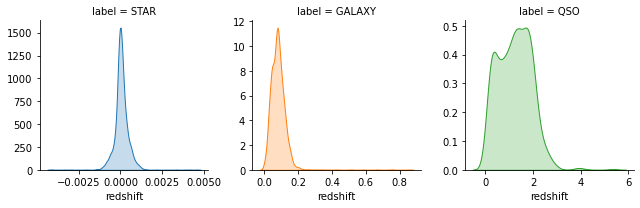

In [10]:
g = sns.FacetGrid(df, col='label', hue='label', margin_titles=True, sharex=False, sharey=False)
g = g.map(sns.kdeplot, 'redshift', shade=True)

In [11]:
target = df['class']
target

0         STAR
1         STAR
2       GALAXY
3         STAR
4         STAR
         ...  
9995    GALAXY
9996    GALAXY
9997      STAR
9998    GALAXY
9999    GALAXY
Name: class, Length: 10000, dtype: object

In [12]:
target.replace({"STAR": 1, "GALAXY": 2, "QSO": 3}, inplace=True)

In [13]:
target

0       1
1       1
2       2
3       1
4       1
       ..
9995    2
9996    2
9997    1
9998    2
9999    2
Name: class, Length: 10000, dtype: int64

In [14]:
profile = pandas_profiling.ProfileReport(df_feat, title='SDSS dataset Report')

In [15]:
profile

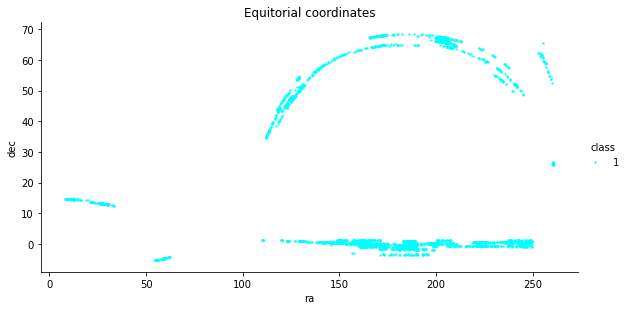

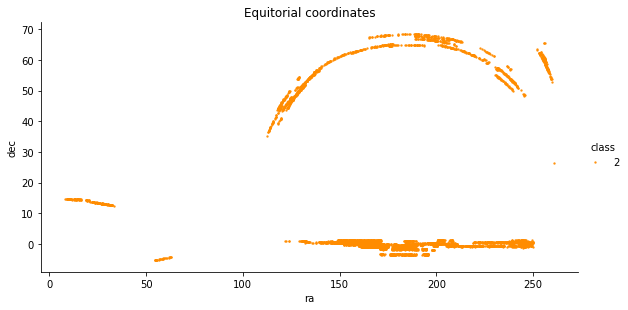

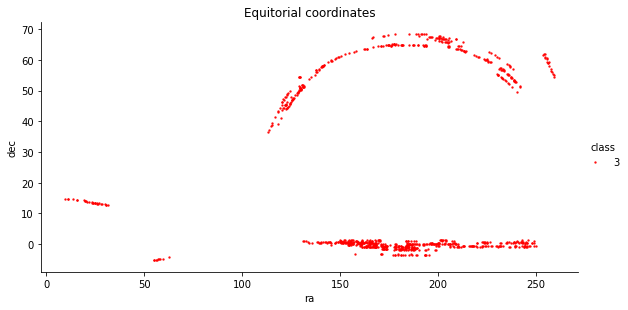

In [16]:
def equitorial(df, row):
    '''Plot equitorial coordinates of observations.'''
    labels = np.unique(df['class'])
    colors = ['aqua', 'darkorange', 'red']
    label = labels[row]
    sns.lmplot(x='ra', y='dec', data=df.loc[df['class']==label],
               hue='class', palette=[colors[row]], scatter_kws={'s': 2}, 
               fit_reg=False, height=4, aspect=2)
    plt.ylabel('dec')
    plt.title('Equitorial coordinates')

    
for row in range(3):
    equitorial(df, row)
    plt.show()

In [17]:
def poly_df (df, degree):
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_data = poly.fit_transform(df)
    poly_columns = poly.get_feature_names(df.columns)
    df_poly = pd.DataFrame(poly_data, columns=poly_columns)
    return df_poly

In [18]:
poly_df = poly_df(df_feat, 2)

In [19]:
poly_df

ra        dec         u         g         r         i         z  \
0     183.531326   0.089693  19.47406  17.04240  15.94699  15.50342  15.22531   
1     183.598371   0.135285  18.66280  17.21449  16.67637  16.48922  16.39150   
2     183.680207   0.126185  19.38298  18.19169  17.47428  17.08732  16.80125   
3     183.870529   0.049911  17.76536  16.60272  16.16116  15.98233  15.90438   
4     183.883288   0.102557  17.55025  16.26342  16.43869  16.55492  16.61326   
...          ...        ...       ...       ...       ...       ...       ...   
9995  131.316413  51.539547  18.81777  17.47053  16.91508  16.68305  16.50570   
9996  131.306083  51.671341  18.27255  17.43849  17.07692  16.71661  16.69897   
9997  131.552562  51.666986  18.75818  17.77784  17.51872  17.43302  17.42048   
9998  131.477151  51.753068  18.88287  17.91068  17.53152  17.36284  17.13988   
9999  131.665012  51.805307  19.27586  17.37829  16.30542  15.83548  15.50588   

      redshift          ra^2       ra dec  ...         r^2         r i  \
0    -0.000009  33683.747513    16.461481  ...  254.306490  247.232884   
1    -0.000055  33708.361650    24.838111  ...  278.101316  274.980334   
2     0.123111  33738.418591    23.177704  ...  305.350462  298.588614   
3    -0.000111  33808.371582     9.177104  ...  261.183093  258.292992   
4     0.000590  33813.063716    18.858473  ...  270.230529  272.141198   
...        ...           ...          ...  ...         ...         ...   
9995  0.027583  17244.000271  6767.988393  ...  286.119931  282.195125   
9996  0.117772  17241.287301  6784.761303  ...  291.621197  285.468212   
9997 -0.000402  17306.076648  6796.924445  ...  306.905550  305.404196   
9998  0.014019  17286.241261  6804.345914  ...  307.354194  304.396977   
9999  0.118417  17335.675411  6820.946435  ...  265.866721  258.204152   

             r z  r redshift         i^2         i z  i redshift         z^2  \
0     242.797866   -0.000143  240.356032  236.044376   -0.000139  231.810065   
1     273.350719   -0.000916  271.894376  270.283050   -0.000905  268.681272   
2     293.589747    2.151280  291.976505  287.088335    2.103640  282.282002   
3     257.033230   -0.001788  255.434872  254.189050   -0.001768  252.949303   
4     273.100231    0.009705  274.065376  275.031190    0.009773  276.000408   
...          ...         ...         ...         ...         ...         ...   
9995  279.195236    0.466568  278.324157  275.365418    0.460168  272.438132   
9996  285.166975    2.011186  279.445050  279.150169    1.968752  278.855599   
9997  305.184511   -0.007035  303.910186  303.691576   -0.007001  303.473123   
9998  300.488149    0.245773  301.468213  297.596994    0.243409  293.775486   
9999  252.829886    1.930844  250.762427  245.543053    1.875195  240.432315   

      z redshift    redshift^2  
0      -0.000136  8.028160e-11  
1      -0.000900  3.014010e-09  
2       2.068422  1.515637e-02  
3      -0.001759  1.223590e-08  
4       0.009808  3.485214e-07  
...          ...           ...  
9995    0.455276  7.608186e-04  
9996    1.966674  1.387029e-02  
9997   -0.006996  1.612609e-07  
9998    0.240283  1.965307e-04  
9999    1.836164  1.402266e-02  

[10000 rows x 44 columns]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(poly_df, target, random_state=34,test_size=0.2)

In [21]:
logreg = LogisticRegression().fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
acc_log = accuracy_score(y_test, logreg_pred)
print(round(acc_log, 2)* 100)

80.0


[[674 149  16]
 [185 811   6]
 [ 22  12 125]]


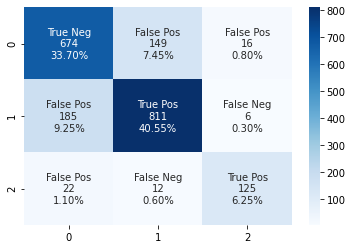

In [22]:
cf_matrix_logreg = confusion_matrix(y_test, logreg_pred)
print(cf_matrix_logreg)

group_names = ['True Neg','False Pos','False Pos', 'False Pos', 'True Pos', 'False Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_logreg.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_logreg.flatten()/np.sum(cf_matrix_logreg)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3
          in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix_logreg, annot=labels, fmt='', cmap='Blues');

In [57]:
data_train, data_test, target_train, target_test = train_test_split(poly_df, target, random_state=42,test_size=0.2)



In [58]:
logreg = LogisticRegression().fit(data_train, target_train)
logreg_pred = logreg.predict(data_test)
acc_log = accuracy_score(target_test, logreg_pred)
print(round(acc_log, 2)* 100)

82.0


In [59]:
# confusion matrix plotter
def plot_confusion_matrix(
    target,
    pred, 
    classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
):

    '''
    Function that prints and plots a model's confusion matrix.
​
​
    Input
    -----
    cm : sklearn confusion matrix
        `sklearn.metrics.confusion_matrix(y_true, y_pred)`
​
    classes : list (str)
        Names of target classes.
​
​
    Optional input
    --------------
    normalize : bool
        Whether to apply normalization (default=False).
        Normalization can be applied by setting `normalize=True`.
​
    title : str
        Title of the returned plot.
​
    cmap : matplotlib color map
        For options, visit:
        `https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html`
​
​
    Output
    ------
    Prints a stylized confusion matrix.

    '''

    # convert to percentage, if normalize set to True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    cm = confusion_matrix(target, pred)

    # plot
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # format true positives and others
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=16,
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # add axes labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


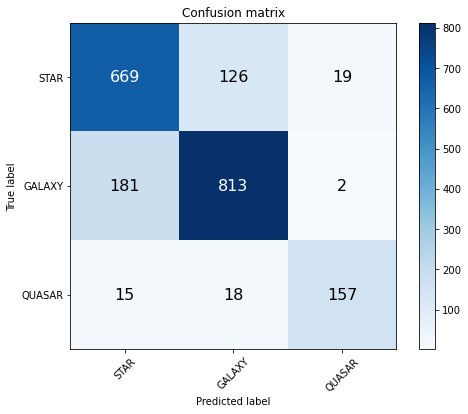

In [60]:
plot_confusion_matrix(
    target_test,
    logreg_pred,
    ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [88]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=logreg, step=2, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

Fitting estimator with 44 features.
Fitting estimator with 42 features.
Fitting estimator with 40 features.
Fitting estimator with 38 features.
Fitting estimator with 36 features.
Fitting estimator with 34 features.
Fitting estimator with 32 features.
Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
Fitting estimator with 14 features.
Fitting estimator with 12 features.
Fitting estimator with 10 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.


RFECV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
      scoring='neg_mean_absolute_error', step=2, verbose=1)

In [89]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [90]:
selected_rfe

Index(['u redshift', 'g redshift'], dtype='object')

In [91]:
RFECV = poly_df[selected_rfe]

In [95]:
data_train_r, data_test_r, target_train_r, target_test_r = train_test_split(RFECV, target, random_state=42,test_size=0.2)

In [92]:
selector = SelectKBest(f_regression, k=2)

selector.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7f835b02e3a0>)

In [93]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [138]:
selected_columns

Index(['redshift', 'u redshift'], dtype='object')

In [94]:
k_best = poly_df[selected_columns]

In [96]:
data_train_k, data_test_k, target_train_k, target_test_k = train_test_split(k_best, target, random_state=42,test_size=0.2)

# Decision Tree Classifier

In [101]:
def decisiontree(data_train, target_train, data_test, target_test, depth):
    dtree_c = DecisionTreeClassifier(max_depth = depth) 
    dtree_c =  dtree_c.fit(data_train, target_train)
    d_tree_pred = dtree_c.predict(data_test)
    d_tree_pred = np.round(d_tree_pred)
    dt_score = accuracy_score(target_test, d_tree_pred)
    print("Accuracy score for Decision Tree {}:".format(dt_score))
    print ("\nClassification report Decision Tree Classifier:\n",(classification_report(target_test, d_tree_pred)))
    return(d_tree_pred)
    
    

In [102]:
decisiontree(data_train, target_train, data_test, target_test, 2)

Accuracy score for Decision Tree 0.988:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



array([2, 3, 2, ..., 1, 1, 2])

Accuracy score for Decision Tree 0.988:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



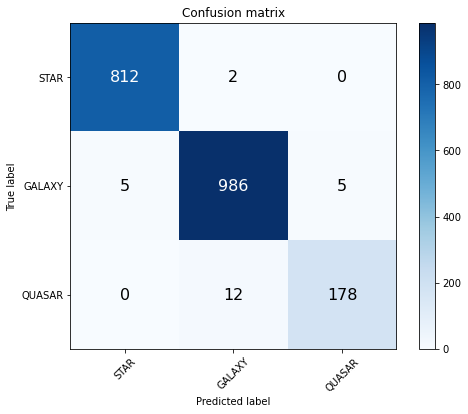

In [106]:
plot_confusion_matrix(
    target_test,
    pred = decisiontree(data_train, target_train, data_test, target_test, 2),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [103]:
decisiontree(data_train_r, target_train_r, data_test_r, target_test_r, 2)

Accuracy score for Decision Tree 0.988:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



array([2, 3, 2, ..., 1, 1, 2])

Accuracy score for Decision Tree 0.988:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



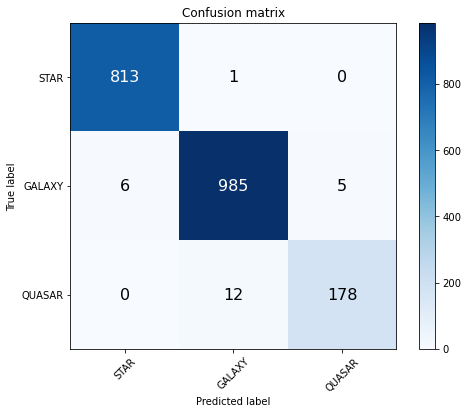

In [107]:
plot_confusion_matrix(
    target_test,
    pred = decisiontree(data_train_r, target_train_r, data_test_r, target_test_r, 2),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [104]:
decisiontree(data_train_k, target_train_k, data_test_k, target_test_r, 2)

Accuracy score for Decision Tree 0.9875:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.93      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



array([2, 3, 2, ..., 1, 1, 2])

Accuracy score for Decision Tree 0.9875:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.93      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



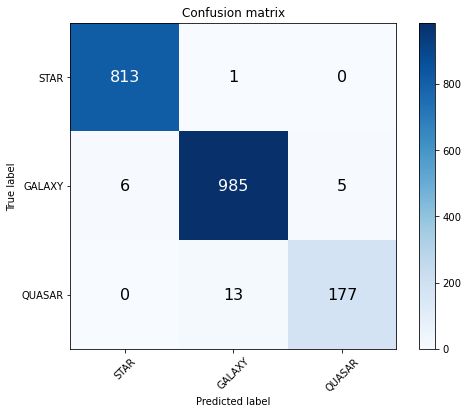

In [108]:
plot_confusion_matrix(
    target_test,
    pred = decisiontree(data_train_k, target_train_k, data_test_k, target_test_r, 2),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

# Random Forest Classifier

In [111]:
def randomforest(data_train, target_train, data_test, target_test,  est, depth):
    jungle = RandomForestClassifier(n_estimators = est, max_depth= depth)
    jungle = jungle.fit(data_train, target_train)
    random_pred = jungle.predict(data_test)
    random_pred = np.round(random_pred)
    print ("\nClassification report Random Forest Classifier Train:\n", (jungle.score(data_train, target_train))) 
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(target_test, random_pred)))
    return(random_pred)

In [112]:
randomforest(data_train, target_train, data_test, target_test, 100, 5)


Classification report Random Forest Classifier Train:
 0.99075

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



array([2, 3, 2, ..., 1, 1, 2])


Classification report Random Forest Classifier Train:
 0.990625

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



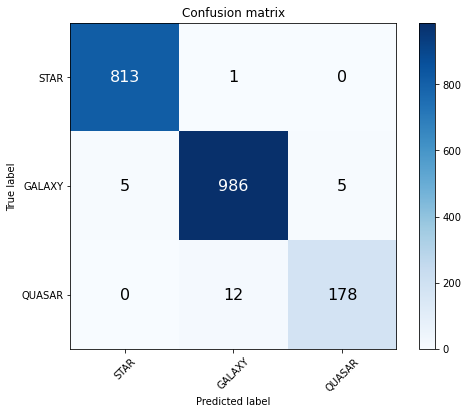

In [115]:
plot_confusion_matrix(
    target_test,
    pred = randomforest(data_train, target_train, data_test, target_test, 100, 5),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [113]:
randomforest(data_train_r, target_train_r, data_test_r, target_test_r,  100, 5)


Classification report Random Forest Classifier Train:
 0.991375

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



array([2, 3, 2, ..., 1, 1, 2])


Classification report Random Forest Classifier Train:
 0.991375

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



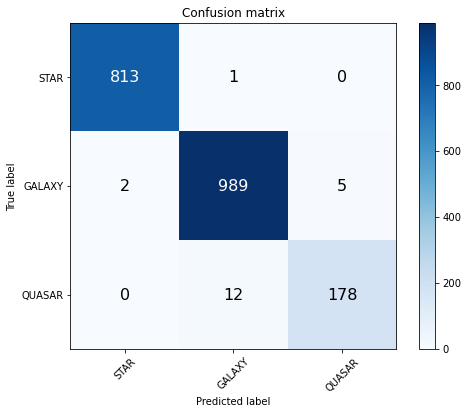

In [116]:
plot_confusion_matrix(
    target_test,
    pred = randomforest(data_train_r, target_train_r, data_test_r, target_test_r,  100, 5),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [114]:
randomforest(data_train_k, target_train_k, data_test_k, target_test_k, 100, 5)


Classification report Random Forest Classifier Train:
 0.99075

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.93      0.95       190

    accuracy                           0.99      2000
   macro avg       0.99      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



array([2, 3, 2, ..., 1, 1, 2])


Classification report Random Forest Classifier Train:
 0.991125

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.98      0.93      0.95       190

    accuracy                           0.99      2000
   macro avg       0.99      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



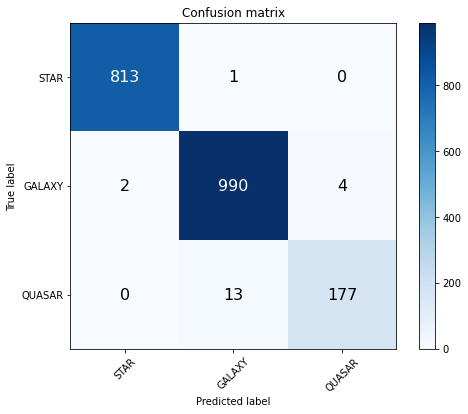

In [117]:
plot_confusion_matrix(
    target_test,
    pred = randomforest(data_train_k, target_train_k, data_test_k, target_test_k, 100, 5),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

# Bagging Classifier

In [118]:
def bagging(data_train, target_train, data_test, target_test,  est, depth, jobs, bool, verbose):
    bagged_tree =  BaggingClassifier(DecisionTreeClassifier(max_depth= depth), 
                                 n_estimators=est, n_jobs = jobs, oob_score=bool, verbose= verbose)
    bagged_tree = bagged_tree.fit(data_train, target_train)
    bagged_pred = bagged_tree.predict(data_test)
    bagged_pred = np.round(bagged_pred)
    print ("\nClassification report Bagging Classifier Train:\n", (bagged_tree.score(data_train, target_train)))
    print ("\nClassification report Bagging Classifier Test:\n", (bagged_tree.score(data_test, target_test)))
    print ("\nClassification report Random Forest Classifier:\n",(classification_report(target_test, bagged_pred)))
    return(bagged_pred)
    

In [119]:
bagging(data_train, target_train, data_test, target_test, 20, 5, -1, True, 1)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    2.8s remaining:   13.9s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    2.9s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.1s finished



Classification report Bagging Classifier Train:
 0.991625

Classification report Bagging Classifier Test:
 0.988

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished


array([2, 3, 2, ..., 1, 1, 2])

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.1s finished



Classification report Bagging Classifier Train:
 0.991625

Classification report Bagging Classifier Test:
 0.9885

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished


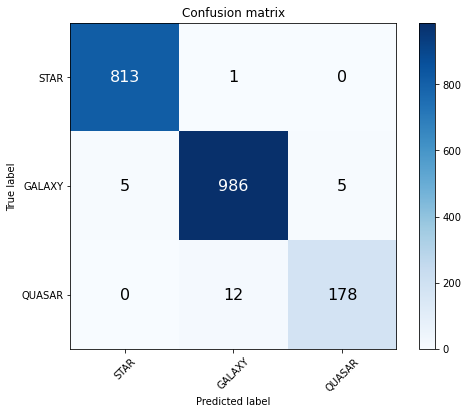

In [120]:
plot_confusion_matrix(
    target_test,
    pred = bagging(data_train, target_train, data_test, target_test, 20, 5, -1, True, 1),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished



Classification report Bagging Classifier Train:
 0.991625

Classification report Bagging Classifier Test:
 0.99

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



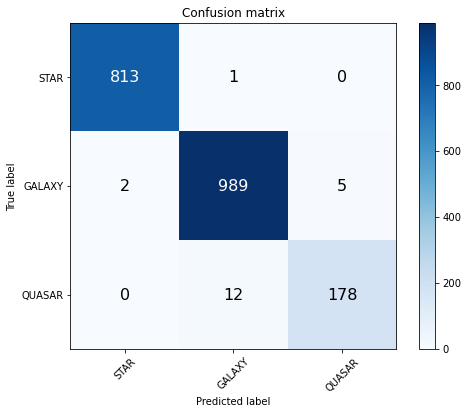

In [121]:
plot_confusion_matrix(
    target_test,
    pred = bagging(data_train_r, target_train_r, data_test_r, target_test_r, 20, 5, -1, True, 1),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished



Classification report Bagging Classifier Train:
 0.990875

Classification report Bagging Classifier Test:
 0.99

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.98      0.93      0.95       190

    accuracy                           0.99      2000
   macro avg       0.99      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



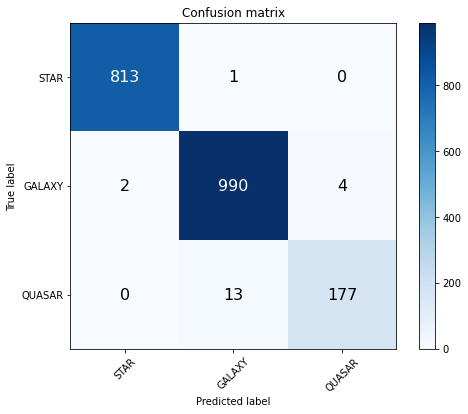

In [122]:
plot_confusion_matrix(
    target_test,
    pred = bagging(data_train_k, target_train_k, data_test_k, target_test_k, 20, 5, -1, True, 1),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

# Resampling minority class using SMOTE

In [140]:
sm = SMOTE(sampling_strategy = 'minority', random_state = 42)
SM_data_train, SM_target_train = sm.fit_resample(data_train, target_train)

In [137]:
SM_target_train.value_counts()

3    4002
2    4002
1    3338
Name: class, dtype: int64

In [127]:
SM_data_train_k, SM_target_train_k = sm.fit_resample(data_train_k, target_train_k)

In [128]:
SM_data_train_r, SM_target_train_r = sm.fit_resample(data_train_r, target_train_r)

Accuracy score for Decision Tree 0.9875:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.95       190

    accuracy                           0.99      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.99      0.99      0.99      2000



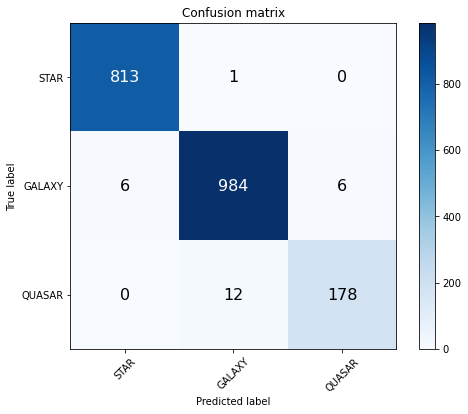

In [123]:
plot_confusion_matrix(
    target_test,
    pred = decisiontree(SM_data_train, SM_target_train, data_test, target_test, 2),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

In [124]:
randomforest(SM_data_train, SM_target_train, data_test, target_test, 100, 5)


Classification report Random Forest Classifier Train:
 0.988273673073532

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.96      0.97       190

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



array([2, 3, 2, ..., 1, 1, 2])


Classification report Random Forest Classifier Train:
 0.9877446658437665

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.95      0.96       190

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



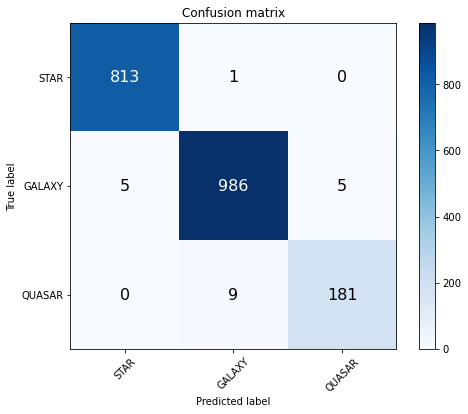

In [125]:
plot_confusion_matrix(
    target_test,
    pred = randomforest(SM_data_train, SM_target_train, data_test, target_test, 100, 5),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    2.5s remaining:   12.5s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    2.8s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished



Classification report Bagging Classifier Train:
 0.9900370305060836

Classification report Bagging Classifier Test:
 0.9895

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.95      0.96       190

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



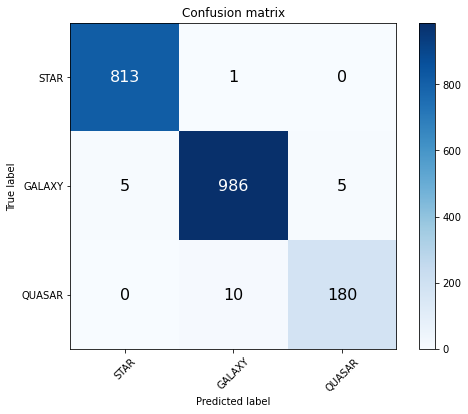

In [126]:
plot_confusion_matrix(
    target_test,
    pred = bagging(SM_data_train, SM_target_train, data_test, target_test, 20, 5, -1, True, 1),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    2.3s remaining:   11.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished



Classification report Bagging Classifier Train:
 0.9794568859107741

Classification report Bagging Classifier Test:
 0.9875

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.94      0.95      0.94       190

    accuracy                           0.99      2000
   macro avg       0.97      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



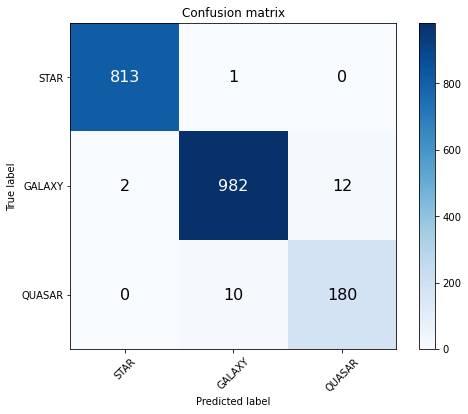

In [129]:
plot_confusion_matrix(
    target_test,
    pred = bagging(SM_data_train_k, SM_target_train_k, data_test_k, target_test_k, 20, 5, -1, True, 1),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished



Classification report Bagging Classifier Train:
 0.9807794039851878

Classification report Bagging Classifier Test:
 0.9905

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       814
           2       0.99      0.99      0.99       996
           3       0.97      0.94      0.96       190

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



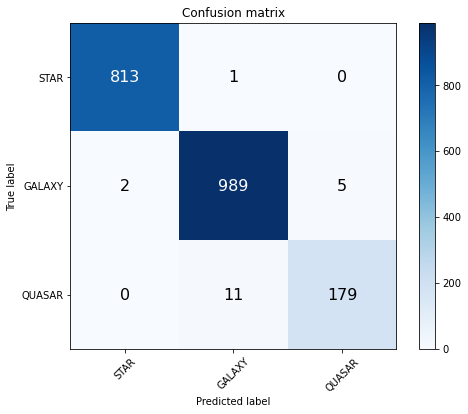

In [130]:
plot_confusion_matrix(
    target_test,
    pred = bagging(SM_data_train_r, SM_target_train_r, data_test_r, target_test_r, 20, 5, -1, True, 1),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

Accuracy score for Decision Tree 0.986:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.98      0.99       996
           3       0.94      0.95      0.95       190

    accuracy                           0.99      2000
   macro avg       0.97      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



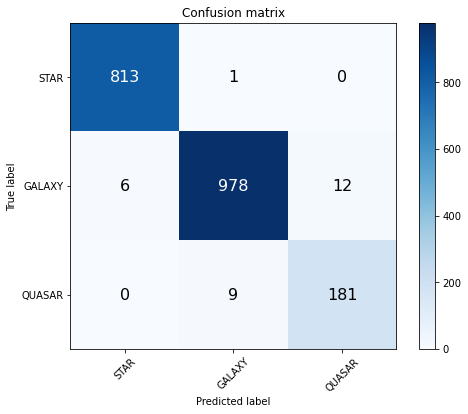

In [132]:
plot_confusion_matrix(
    target_test,
    pred = decisiontree(SM_data_train_r, SM_target_train_r, data_test_r, target_test_r, 2),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)

Accuracy score for Decision Tree 0.9845:

Classification report Decision Tree Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.98      0.98       996
           3       0.92      0.96      0.94       190

    accuracy                           0.98      2000
   macro avg       0.97      0.98      0.97      2000
weighted avg       0.98      0.98      0.98      2000



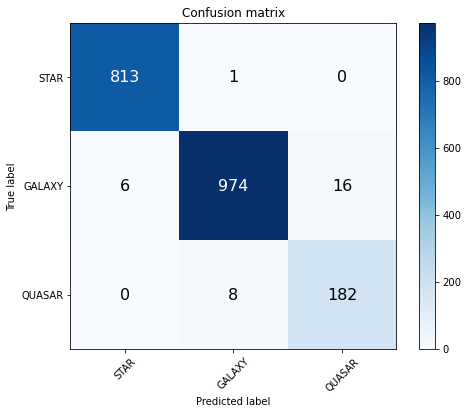

In [133]:
plot_confusion_matrix(
    target_test,
    pred = decisiontree(SM_data_train_k, SM_target_train_k, data_test_k, target_test_k, 2),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)


Classification report Random Forest Classifier Train:
 0.973637806383354

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.98      0.98       996
           3       0.92      0.95      0.94       190

    accuracy                           0.98      2000
   macro avg       0.97      0.98      0.97      2000
weighted avg       0.98      0.98      0.98      2000



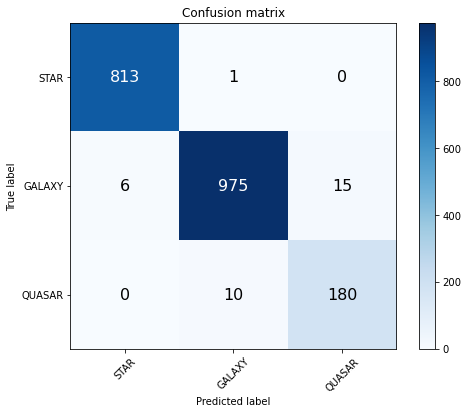

In [134]:
plot_confusion_matrix(
    target_test,
    pred = randomforest(SM_data_train_r, SM_target_train_r, data_test_r, target_test_r, 100, 2),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)


Classification report Random Forest Classifier Train:
 0.9735496385117264

Classification report Random Forest Classifier:
               precision    recall  f1-score   support

           1       0.99      1.00      1.00       814
           2       0.99      0.98      0.98       996
           3       0.92      0.95      0.94       190

    accuracy                           0.98      2000
   macro avg       0.97      0.98      0.97      2000
weighted avg       0.98      0.98      0.98      2000



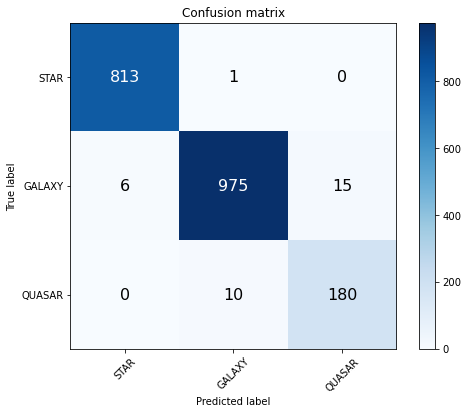

In [135]:
plot_confusion_matrix(
    target_test,
    pred = randomforest(SM_data_train_k, SM_target_train_k, data_test_k, target_test_k, 100, 2),
    classes = ['STAR', 'GALAXY', 'QUASAR'], # put your list here
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
)